# A

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

RANDOM_SEED = 9091
BATCH_SIZE = 64

# A1: Data Preparation

# Loading MNIST  + Normalize

- first we loaded training-MNIST dataset then test-MNIST
- after that

In [ ]:
mnist_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),   # it turns to float32 and div by 255, making normalization
)

mnist_testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)


x_load_train = mnist_training_data.data.numpy()
y_load_train = mnist_training_data.targets.numpy()

x_load_test  = mnist_testing_data.data.numpy()
y_load_test  = mnist_testing_data.targets.numpy()

x_all = np.concatenate([x_load_train, x_load_test], axis=0).astype("float32") / 255.0
y_all = np.concatenate([y_load_train, y_load_test], axis=0)


## Spliting 60-20-20

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x_all, y_all,
    test_size=0.4,
    stratify=y_all,
    random_state=RANDOM_SEED,
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_SEED,
)

x_train = x_train.reshape(-1, 1, 28, 28) # to (N, 1, 28, 28)
x_val   = x_val.reshape(-1, 1, 28, 28)
x_test  = x_test.reshape(-1, 1, 28, 28)

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape,   y_val.shape)
print("Test: ", x_test.shape,  y_test.shape)

Train: (42000, 1, 28, 28) (42000,)
Val:   (14000, 1, 28, 28) (14000,)
Test:  (14000, 1, 28, 28) (14000,)


## To tensors & datasets & loaders

In [ ]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(x_train, y_train)
val_ds   = TensorDataset(x_val,   y_val)
test_ds  = TensorDataset(x_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print(x_train.shape, y_train.shape)
print(x_val.shape,   y_val.shape)
print(x_test.shape,  y_test.shape)

torch.Size([42000, 1, 28, 28]) torch.Size([42000])
torch.Size([14000, 1, 28, 28]) torch.Size([14000])
torch.Size([14000, 1, 28, 28]) torch.Size([14000])


# A2 - Binary Logistic Regression on MNIST

# Filtering the dataset

filterign the dataset to hold only 2 digits (binary calsses) to apply Logistic Reg

## Example To Demonstrate Filtering

In [ ]:
import numpy as np

x = np.array([1,2,3,4])
x[np.array([True,True, False , False])]

array([1, 2])

In [ ]:
# Picking 2 Digits for calsification
DIGIT_A, DIGIT_B = 0, 1

def filter_digits(x, y, a, b):
    mask = (y == a) | (y == b)
    x_filtered = x[mask]
    y_filtered = y[mask]
    y_filtered = (y_filtered == b).long() # 3asha ne3mel trans form bolean to 0,1
    return x_filtered, y_filtered

x_train_bin, y_train_bin = filter_digits(x_train, y_train, DIGIT_A, DIGIT_B)
x_val_bin, y_val_bin     = filter_digits(x_val,   y_val,   DIGIT_A, DIGIT_B)
x_test_bin, y_test_bin   = filter_digits(x_test,  y_test,  DIGIT_A, DIGIT_B)


## Logistic Regression Model

In [ ]:
class LogisticRegressionBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 1)  # input 784 features, output: 1 prob

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        print(x.size())
        logits = self.linear(x)
        probs = torch.sigmoid(logits)
        return probs


# Training Loop

using Binary Cross Entropy Loss and SGD with learing Rate = 0.01

In [ ]:
model = LogisticRegressionBinary()
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

EPOCHS = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

train_ds_bin = TensorDataset(x_train_bin, y_train_bin)
train_loader_bin = DataLoader(train_ds_bin, batch_size=BATCH_SIZE, shuffle=True)

val_ds_bin = TensorDataset(x_val_bin, y_val_bin)
val_loader_bin = DataLoader(val_ds_bin, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    tic = time.time()
    for x_batch, y_batch in train_loader_bin:
        print(y_batch)
        y_batch = y_batch.float().unsqueeze(1)      # Convert labels -> float and (N,1) shape

        optimizer.zero_grad()
        predicted_p = model(x_batch)
        loss = criterion(predicted_p, y_batch.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += ((predicted_p > 0.5).long() == y_batch.long()).sum().item()

    train_loss = total_loss
    train_acc = correct / len(train_loader_bin.dataset)
    toc = time.time()

    LogisticRegressionTime = toc-tic

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss, correct_val, total_val = 0, 0, 0
        for x_batch_val, y_batch_val in val_loader_bin:
            x_batch_val = x_batch_val.view(x_batch_val.size(0), -1)
            y_batch_val = y_batch_val.float().unsqueeze(1)

            val_predicted_p = model(x_batch_val)
            val_loss_batch = criterion(val_predicted_p, y_batch_val)

            total_val_loss += val_loss_batch.item() * x_batch_val.size(0)
            correct_val += ((val_predicted_p > 0.5).long() == y_batch_val.long()).sum().item()

        val_loss = total_val_loss
        val_acc = correct_val / len(val_loader_bin.dataset)


    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}  | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print(LogisticRegressionTime)

Streaming output truncated to the last 5000 lines.
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1])
torch.Size([64, 784])
tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1])
torch.Size([64, 784])
tensor([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1])
torch.Size([64, 784])
tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0])
torch.Size([64,

## Plot Training Curves

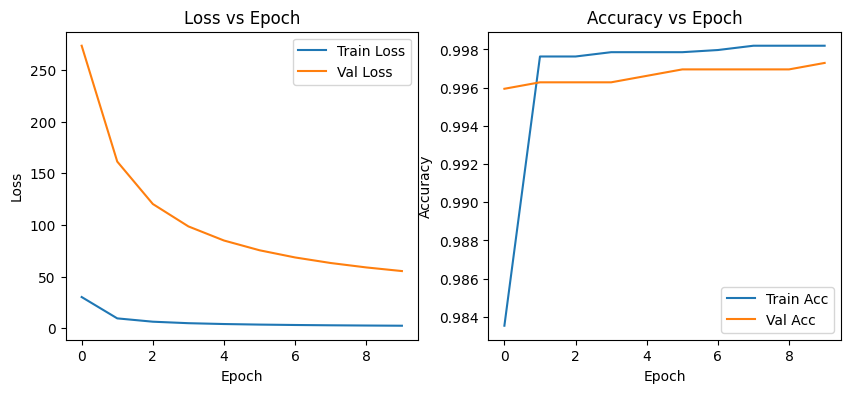

In [ ]:
# Loss curve
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch')
plt.legend()

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()


## Confusion Matrix on Test Set

torch.Size([2955, 784])
Test Accuracy: 0.9963




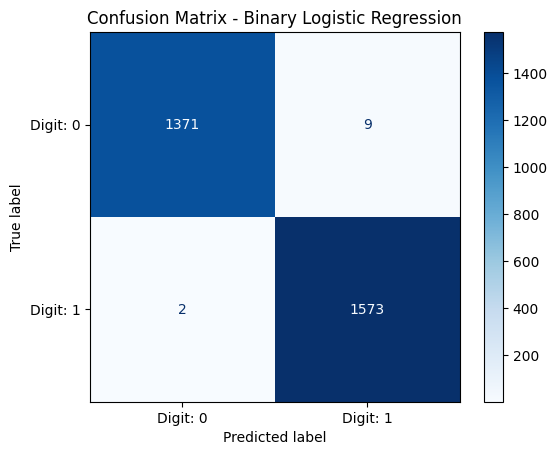

In [ ]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test_bin.view(x_test_bin.size(0), -1))
    y_test_pred_labels = (y_test_pred > 0.5).long().squeeze()
    test_acc = (y_test_pred_labels == y_test_bin).float().mean().item()

print(f"Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(y_test_bin, y_test_pred_labels) # compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Digit: 0", "Digit: 1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Binary Logistic Regression")
print("\n")
plt.show()

# A3: SoftMax

## the Model

In [ ]:


class SoftmaxLinear(nn.Module):
    def __init__(self, in_features=28*28, n_classes=10):
        super().__init__()
        self.linear = nn.Linear(in_features, n_classes)

    def forward(self, x):
        # x shape: (B, 1, 28, 28) or (B, 784)
        if x.dim() == 4:
            x = x.view(x.size(0), -1)   # flatten if needed
        logits = self.linear(x)        # return raw logits (no softmax)
        return logits

LR = 0.01
EPOCHS = 12
BATCH_SIZE = 64

model = SoftmaxLinear()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [ ]:
train_ds = TensorDataset(x_train, y_train)
val_ds   = TensorDataset(x_val,   y_val)
test_ds  = TensorDataset(x_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

## train softmax linear model using CrossEntropyLoss

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    tic = time.time()
    for xb, yb in train_loader:
        xb = xb.view(xb.size(0), -1)      # flatten to (B, 784)
        # yb is long tensor (B,) already — CrossEntropyLoss expects this
        optimizer.zero_grad()
        logits = model(xb)                # shape (B, 10)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    toc = time.time()

    SoftmaxTime = toc-tic

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb_val, yb_val in val_loader:
            xb_val = xb_val.view(xb_val.size(0), -1)
            logits_val = model(xb_val)
            loss_val = criterion(logits_val, yb_val)

            val_running_loss += loss_val.item() * xb_val.size(0)
            preds_val = logits_val.argmax(dim=1)
            val_correct += (preds_val == yb_val).sum().item()
            val_total += xb_val.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print(SoftmaxTime)


Epoch 1/12 | Train Loss: 1.1060 | Val Loss: 0.7098 | Train Acc: 0.7854 | Val Acc: 0.8469
Epoch 2/12 | Train Loss: 0.6155 | Val Loss: 0.5541 | Train Acc: 0.8624 | Val Acc: 0.8636
Epoch 3/12 | Train Loss: 0.5160 | Val Loss: 0.4905 | Train Acc: 0.8756 | Val Acc: 0.8724
Epoch 4/12 | Train Loss: 0.4679 | Val Loss: 0.4546 | Train Acc: 0.8828 | Val Acc: 0.8769
Epoch 5/12 | Train Loss: 0.4383 | Val Loss: 0.4307 | Train Acc: 0.8881 | Val Acc: 0.8833
Epoch 6/12 | Train Loss: 0.4178 | Val Loss: 0.4136 | Train Acc: 0.8923 | Val Acc: 0.8869
Epoch 7/12 | Train Loss: 0.4025 | Val Loss: 0.4003 | Train Acc: 0.8950 | Val Acc: 0.8890
Epoch 8/12 | Train Loss: 0.3905 | Val Loss: 0.3902 | Train Acc: 0.8970 | Val Acc: 0.8916
Epoch 9/12 | Train Loss: 0.3808 | Val Loss: 0.3815 | Train Acc: 0.8989 | Val Acc: 0.8939
Epoch 10/12 | Train Loss: 0.3726 | Val Loss: 0.3742 | Train Acc: 0.9007 | Val Acc: 0.8956
Epoch 11/12 | Train Loss: 0.3658 | Val Loss: 0.3680 | Train Acc: 0.9025 | Val Acc: 0.8963
Epoch 12/12 | Train

## Plotting

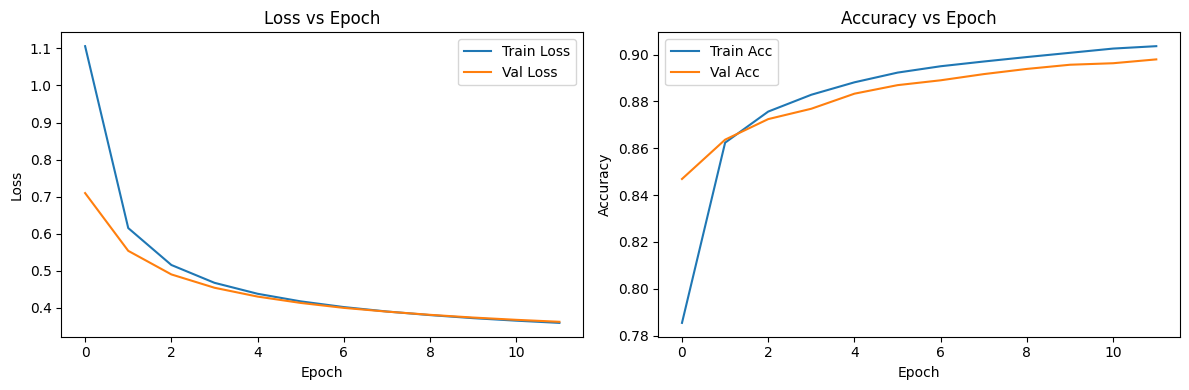

In [ ]:
# Brief: visualize training and validation loss & accuracy over epochs.

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend()

plt.tight_layout()
plt.show()


## Test evaluation, confusion matrix

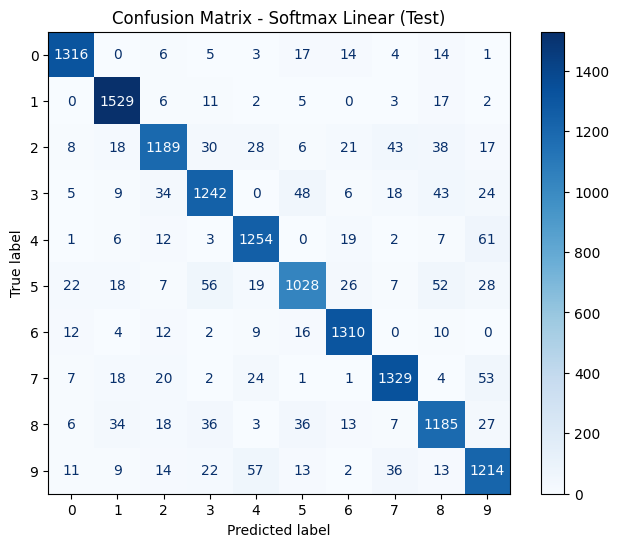

In [ ]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb_t, yb_t in test_loader:
        xb_t = xb_t.view(xb_t.size(0), -1)
        logits_t = model(xb_t)
        preds_t = logits_t.argmax(dim=1)
        all_preds.extend(preds_t.cpu().numpy())
        all_labels.extend(yb_t.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix - Softmax Linear (Test)")
plt.show()

# B AND C

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
isinstance(nn.ReLU , nn.Linear)

False

## Model with Configurable Architecture

In [ ]:
class DigitRecognisionModel(nn.Module):
  def __init__(self,input_size,hidden_sizes :list[int],output_size):
    super().__init__()
    self.flatten = nn.Flatten()
    layer_sizes = [input_size] + hidden_sizes
    layers = []

    for i in range(len(layer_sizes)-1):
      layers.append(nn.Linear(layer_sizes[i] , layer_sizes[i+1]))
      layers.append(nn.ReLU())

    layers.append(nn.Linear(layer_sizes[-1] , output_size))
    self.linear_relu_stack = nn.Sequential(*layers)


  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits


## Using GPU if Possible for faster Training & Initialization of the Model

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
model = DigitRecognisionModel(28*28 , [512,512] , 10 )
model.to(device)
print(model)

DigitRecognisionModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Weights Initialization Using He (Most Suitable for ReLU)

In [ ]:
def init_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_xavier)

DigitRecognisionModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Example on Accuracy and Loss

In [ ]:
logits = torch.tensor([[2.0, 1.0, 0.1], [0.5, 2.5, 0.3], [0.2, 0.8, 1.5]])
targets = torch.tensor([0, 1, 0]) # -100 will be ignored
criterion = nn.CrossEntropyLoss()

loss = criterion(logits, targets)
correct = (torch.argmax(logits, dim=1) == targets).sum().item()
print(f"Accuracy : {correct/len(targets)*100}")
print(f"Loss: {loss.item()}")

Accuracy : 66.66666666666666
Loss: 0.8358533382415771


## Train Loop

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss , correct = 0,0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct+= (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss / len(dataloader) ,  correct/size * 100

## Validation and Testing

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct*100

## Train Config

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## Training

In [ ]:
epochs = 10
train_losses,test_losses,train_accuracies,test_accuracies = [],[],[],[]

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss,train_accuracy = train(train_loader, model, loss_fn, optimizer)
    test_loss,test_accuracy = test(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print("Done!")

print("Train Losses:", train_losses)
print("Test Losses:", test_losses)
print("Train Accuracies:", train_accuracies)
print("Test Accuracies:", test_accuracies)

Epoch 1
-------------------------------
loss: 2.534475  [   64/42000]
loss: 1.394789  [ 6464/42000]
loss: 0.776607  [12864/42000]
loss: 0.536278  [19264/42000]
loss: 0.532961  [25664/42000]
loss: 0.464023  [32064/42000]
loss: 0.404343  [38464/42000]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.410940 

Epoch 2
-------------------------------
loss: 0.304046  [   64/42000]
loss: 0.374687  [ 6464/42000]
loss: 0.204357  [12864/42000]
loss: 0.440840  [19264/42000]
loss: 0.440657  [25664/42000]
loss: 0.358433  [32064/42000]
loss: 0.259336  [38464/42000]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.325043 

Epoch 3
-------------------------------
loss: 0.401648  [   64/42000]
loss: 0.317791  [ 6464/42000]
loss: 0.512482  [12864/42000]
loss: 0.298759  [19264/42000]
loss: 0.215452  [25664/42000]
loss: 0.152648  [32064/42000]
loss: 0.194383  [38464/42000]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.280825 

Epoch 4
-------------------------------
loss: 0.231189  [   64/42000]
loss: 0.324932  [ 6464/4

## Plots

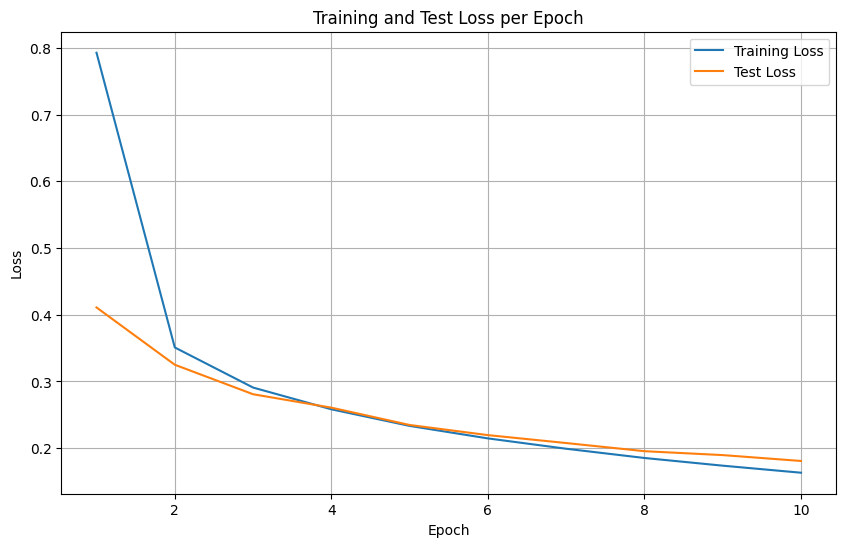

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

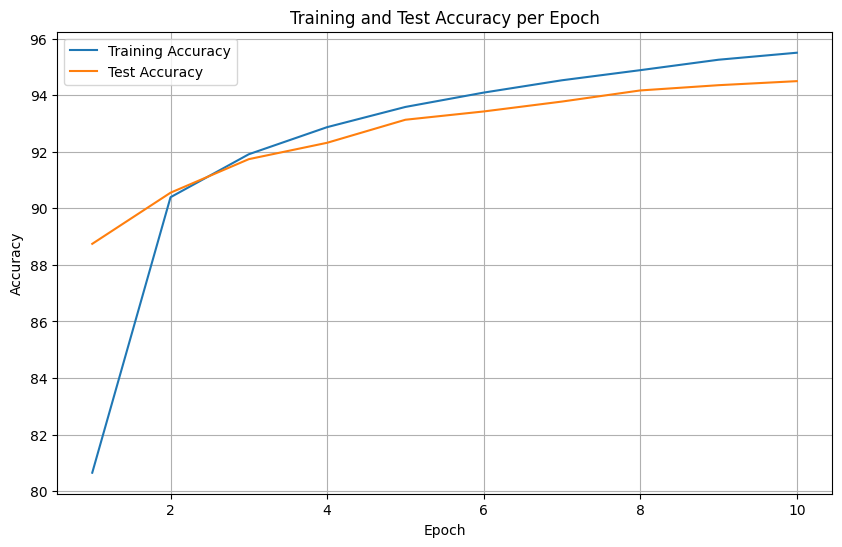

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Learning curves with error bars

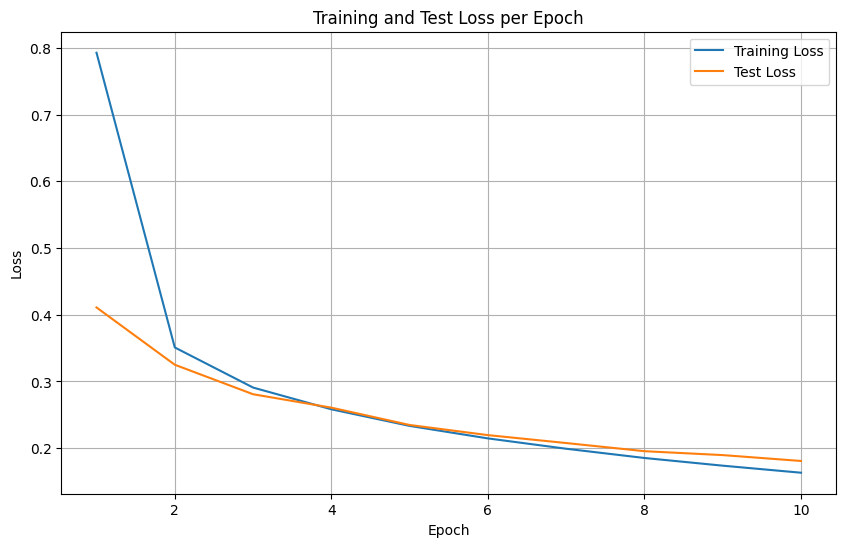

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(range(1, epochs + 1), train_losses, label='Training Loss')
plt.errorbar(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
train_dataloader = train_loader
test_dataloader = val_loader

## Systematic Analysis

In [ ]:
def make_model_and_optimizer(lr = 0.01 , hidden_sizes=[512,512],  ):
  device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
  model = DigitRecognisionModel(28*28 , hidden_sizes , 10 )
  model.to(device)
  model.apply(init_xavier)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  return model,optimizer

In [ ]:
epochs = 1

loss: 2.358595  [   64/42000]
loss: 1.223057  [ 6464/42000]
loss: 0.674936  [12864/42000]
loss: 0.563881  [19264/42000]
loss: 0.626791  [25664/42000]
loss: 0.563455  [32064/42000]
loss: 0.496611  [38464/42000]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.415287 

loss: 2.436733  [   64/42000]
loss: 1.245974  [ 6464/42000]
loss: 0.711469  [12864/42000]
loss: 0.558565  [19264/42000]
loss: 0.475824  [25664/42000]
loss: 0.344301  [32064/42000]
loss: 0.410334  [38464/42000]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.417519 

loss: 2.503535  [   64/42000]
loss: 1.165823  [ 6464/42000]
loss: 0.826599  [12864/42000]
loss: 0.564018  [19264/42000]
loss: 0.524340  [25664/42000]
loss: 0.493598  [32064/42000]
loss: 0.425387  [38464/42000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.405386 

loss: 2.509496  [   64/42000]
loss: 1.206477  [ 6464/42000]
loss: 0.855179  [12864/42000]
loss: 0.653151  [19264/42000]
loss: 0.663666  [25664/42000]
loss: 0.407555  [32064/42000]
loss: 0.569671  [38464/42000]
Test

Text(0.5, 1.0, 'Test Accuracy vs Learning Rate')

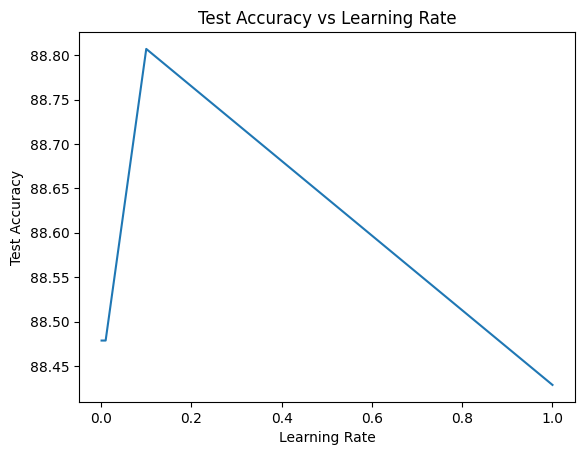

In [ ]:
test_accuracies_per_lr = []
for lr in [0.001, 0.01, 0.1, 1.0]:
    model,optimizer = make_model_and_optimizer(lr)
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        _,test_accuracy = test(test_dataloader, model, loss_fn)
    test_accuracies_per_lr.append(test_accuracy)
plt.plot([0.001, 0.01, 0.1, 1.0], test_accuracies_per_lr)
plt.xlabel('Learning Rate')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Learning Rate')

loss: 2.511906  [   64/42000]
loss: 1.627807  [ 6464/42000]
loss: 0.929625  [12864/42000]
loss: 0.659257  [19264/42000]
loss: 0.684609  [25664/42000]
loss: 0.434349  [32064/42000]
loss: 0.470138  [38464/42000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.456867 

loss: 2.427787  [   64/42000]
loss: 1.551393  [ 6464/42000]
loss: 1.079561  [12864/42000]
loss: 0.930071  [19264/42000]
loss: 0.527604  [25664/42000]
loss: 0.527828  [32064/42000]
loss: 0.379986  [38464/42000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.467949 

loss: 2.324042  [   64/42000]
loss: 1.298466  [ 6464/42000]
loss: 0.933761  [12864/42000]
loss: 0.564553  [19264/42000]
loss: 0.528310  [25664/42000]
loss: 0.518135  [32064/42000]
loss: 0.530560  [38464/42000]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.432109 

loss: 2.359211  [   64/42000]
loss: 1.170906  [ 6464/42000]
loss: 0.798645  [12864/42000]
loss: 0.556864  [19264/42000]
loss: 0.642905  [25664/42000]
loss: 0.305865  [32064/42000]
loss: 0.591096  [38464/42000]
Test

Text(0.5, 1.0, 'Test Accuracy vs Hidden Size')

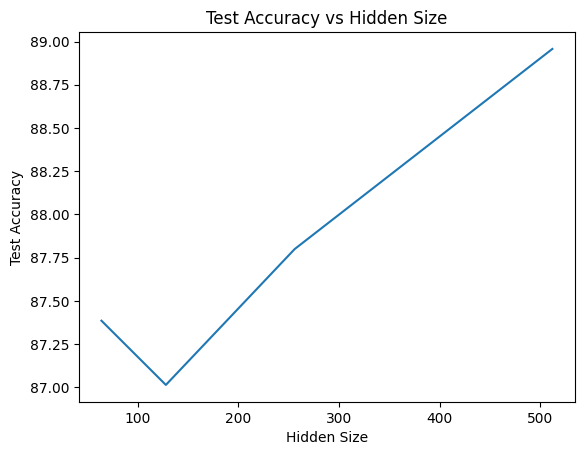

In [ ]:
test_accuracies_per_hidden_size = []
for hidden_size in  [64, 128, 256, 512]:
    model,optimizer = make_model_and_optimizer(hidden_sizes=[hidden_size,hidden_size])
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        _,test_accuracy = test(test_dataloader, model, loss_fn)
    test_accuracies_per_hidden_size.append(test_accuracy)
plt.plot([64, 128, 256, 512], test_accuracies_per_hidden_size)
plt.xlabel('Hidden Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Hidden Size')


loss: 2.392184  [   64/42000]
loss: 1.163499  [ 6464/42000]
loss: 0.652293  [12864/42000]
loss: 0.621837  [19264/42000]
loss: 0.589359  [25664/42000]
loss: 0.440651  [32064/42000]
loss: 0.498253  [38464/42000]
Test Error: 
 Accuracy: 88.8%, Avg loss: 0.401249 

loss: 2.427035  [   64/42000]
loss: 1.134571  [ 6464/42000]
loss: 0.556783  [12864/42000]
loss: 0.453234  [19264/42000]
loss: 0.442800  [25664/42000]
loss: 0.445100  [32064/42000]
loss: 0.418937  [38464/42000]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.385802 

loss: 2.397736  [   64/42000]
loss: 1.057701  [ 6464/42000]
loss: 0.452298  [12864/42000]
loss: 0.450483  [19264/42000]
loss: 0.355585  [25664/42000]
loss: 0.403116  [32064/42000]
loss: 0.330033  [38464/42000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.315595 

loss: 2.453949  [   64/42000]
loss: 0.831863  [ 6464/42000]
loss: 0.463784  [12864/42000]
loss: 0.386658  [19264/42000]
loss: 0.387609  [25664/42000]
loss: 0.451562  [32064/42000]
loss: 0.296442  [38464/42000]
Test

Text(0.5, 1.0, 'Test Accuracy vs Layers Number')

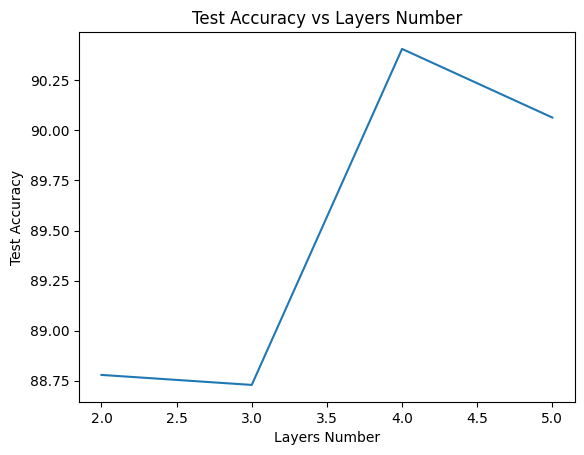

In [ ]:
test_accuracies_per_layers_num = []
for layers_num in  [2, 3, 4, 5]:
    model,optimizer = make_model_and_optimizer(hidden_sizes=[512]*layers_num)
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        _,test_accuracy = test(test_dataloader, model, loss_fn)
        test_accuracies_per_layers_num.append(test_accuracy)
plt.plot([2, 3, 4, 5], test_accuracies_per_layers_num)
plt.xlabel('Layers Number')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Layers Number')

loss: 2.253476  [   16/42000]
loss: 1.560326  [ 1616/42000]
loss: 0.798677  [ 3216/42000]
loss: 0.534417  [ 4816/42000]
loss: 0.766471  [ 6416/42000]
loss: 0.494278  [ 8016/42000]
loss: 0.774199  [ 9616/42000]
loss: 0.434690  [11216/42000]
loss: 0.284191  [12816/42000]
loss: 0.583050  [14416/42000]
loss: 0.433782  [16016/42000]
loss: 0.218860  [17616/42000]
loss: 0.312124  [19216/42000]
loss: 0.129246  [20816/42000]
loss: 0.192859  [22416/42000]
loss: 0.168589  [24016/42000]
loss: 0.074162  [25616/42000]
loss: 0.045659  [27216/42000]
loss: 0.816619  [28816/42000]
loss: 0.163412  [30416/42000]
loss: 0.275597  [32016/42000]
loss: 0.133554  [33616/42000]
loss: 0.371463  [35216/42000]
loss: 0.339710  [36816/42000]
loss: 0.256921  [38416/42000]
loss: 0.873739  [40016/42000]
loss: 0.278595  [41616/42000]
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.269561 

loss: 2.241024  [   32/42000]
loss: 1.255191  [ 3232/42000]
loss: 0.827584  [ 6432/42000]
loss: 0.913822  [ 9632/42000]
loss: 0.792344  [1

Text(0.5, 1.0, 'Test Accuracy vs Batch Size')

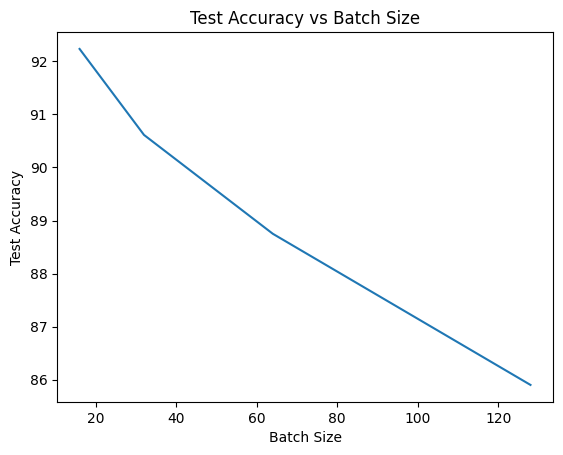

In [ ]:
test_accuracies_per_batch_size = []
for batch_size in  [16, 32, 64, 128]:
    train_dataloader = DataLoader(train_ds, batch_size=batch_size)
    test_dataloader = DataLoader(val_ds, batch_size=batch_size)
    model,optimizer = make_model_and_optimizer()
    for t in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)
        _,test_accuracy = test(test_dataloader, model, loss_fn)
    test_accuracies_per_batch_size.append(test_accuracy)
plt.plot([16, 32, 64, 128], test_accuracies_per_batch_size)
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Batch Size')

In [ ]:
epochs = 10

In [ ]:
import time
tic = time.time()
train_dataloader = DataLoader(train_ds, batch_size=16)
test_dataloader = DataLoader(val_ds, batch_size=16)
model,optimizer = make_model_and_optimizer(hidden_sizes=[512]*4,lr=0.01)
for t in range(epochs):
    train(train_dataloader, model, loss_fn, optimizer)
    _,test_accuracy = test(test_dataloader, model, loss_fn)
toc = time.time()

NNTime = toc-tic
print(f"Model Accuracy : {test_accuracy}")

loss: 2.290163  [   16/42000]
loss: 1.073567  [ 1616/42000]
loss: 0.581175  [ 3216/42000]
loss: 0.273904  [ 4816/42000]
loss: 0.678463  [ 6416/42000]
loss: 0.612622  [ 8016/42000]
loss: 0.726154  [ 9616/42000]
loss: 0.266745  [11216/42000]
loss: 0.123758  [12816/42000]
loss: 0.410840  [14416/42000]
loss: 0.362123  [16016/42000]
loss: 0.104957  [17616/42000]
loss: 0.330981  [19216/42000]
loss: 0.100876  [20816/42000]
loss: 0.115820  [22416/42000]
loss: 0.122348  [24016/42000]
loss: 0.028914  [25616/42000]
loss: 0.078754  [27216/42000]
loss: 0.660424  [28816/42000]
loss: 0.133606  [30416/42000]
loss: 0.145223  [32016/42000]
loss: 0.104166  [33616/42000]
loss: 0.314254  [35216/42000]
loss: 0.282587  [36816/42000]
loss: 0.108806  [38416/42000]
loss: 0.647737  [40016/42000]
loss: 0.287695  [41616/42000]
Test Error: 
 Accuracy: 93.6%, Avg loss: 0.212090 

loss: 0.279044  [   16/42000]
loss: 0.227703  [ 1616/42000]
loss: 0.297889  [ 3216/42000]
loss: 0.070879  [ 4816/42000]
loss: 0.316972  [ 

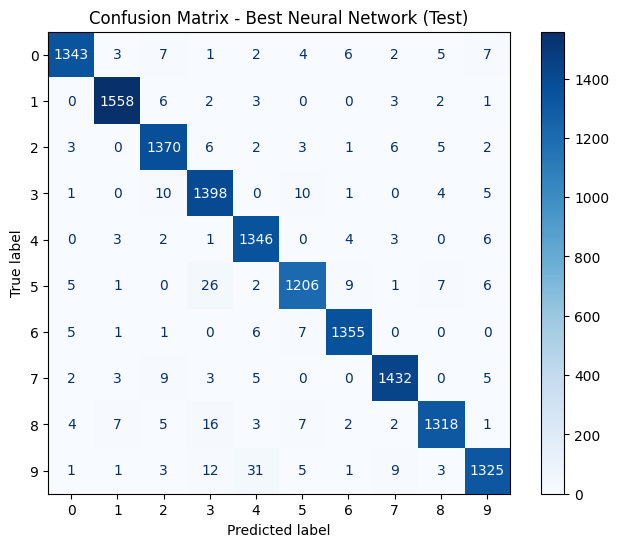

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for xb_t, yb_t in test_loader:
        xb_t = xb_t.to(device)
        logits_t = model(xb_t)
        preds_t = logits_t.argmax(dim=1)
        all_preds.extend(preds_t.cpu().numpy())
        all_labels.extend(yb_t.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title("Confusion Matrix - Best Neural Network (Test)")
plt.show()

In [ ]:
print(NNTime)

61.07016086578369


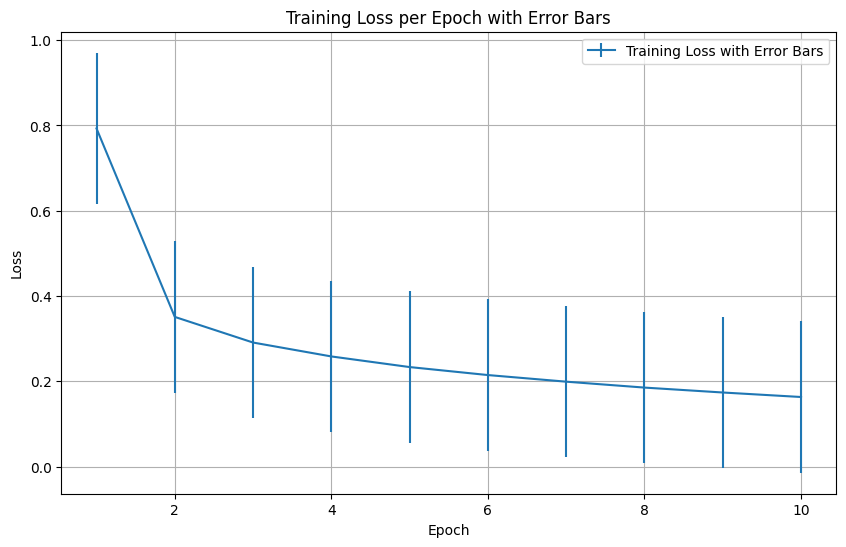

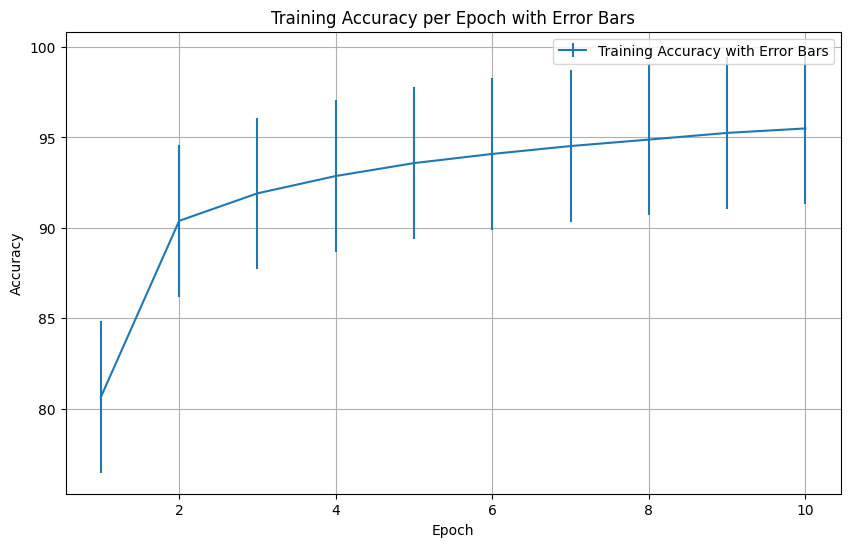

In [ ]:
plt.figure(figsize=(10,6))
plt.errorbar(range(1, epochs + 1), train_losses, yerr=np.std(train_losses), label='Training Loss with Error Bars')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(range(1, epochs + 1), train_accuracies, yerr=np.std(train_accuracies), label='Training Accuracy with Error Bars')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

| Compare By | Logistic Regression | Softmax | Neural Network |
|-------------|---------------------|----------|----------------|
| Time        |          0.21s        |    0.76s      |   61.07s             |
|complexity   |         o(d)        |    o(d k)    |  o(product of neurons by) layer           |


# D

In [ ]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

# just loading mnist dataset as well as normalizing pixels from 0-255 to 0-1

In [ ]:
(x_load_train,y_load_train),(x_load_test,y_load_test)=keras.datasets.mnist.load_data()
x_all = np.concatenate((x_load_train, x_load_test), axis=0)
y_all = np.concatenate((y_load_train, y_load_test), axis=0)
x_all = x_all.astype('float32') / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#split *data*  + reshape to be suitable for 2d cnn

In [ ]:
x_train,x_temp,y_train,y_temp=train_test_split(x_all, y_all, test_size=0.4,stratify=y_all, random_state=42)

x_val,x_test,y_val,y_test=train_test_split(x_temp, y_temp, test_size=0.5,stratify=y_temp, random_state=42)
x_train = x_train.reshape(-1, 1, 28, 28)
x_val = x_val.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)  # [num of samples,scale color gray scale or rgbc,rows,columns]


# convet to pytorch tensors  to deal with pytorch

In [ ]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)

x_val = torch.tensor(x_val)
y_val = torch.tensor(y_val)

x_test = torch.tensor(x_test)
y_test = torch.tensor(y_test)


# tensor dataaset connect sample features with its label in pytorch

In [ ]:
Training_dataset = TensorDataset(x_train, y_train)
Validation_dataset = TensorDataset(x_val, y_val)
Test_dataset = TensorDataset(x_test, y_test)

# Dataloaders to divide into batches so can fit in memory

In [ ]:
train_loader = DataLoader(Training_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(Validation_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(Test_dataset, batch_size=64, shuffle=False)


In [ ]:
print(x_train.min(), x_train.max())

tensor(0.) tensor(1.)


# build the cnn model with batch normalize




In [ ]:
import torch
import torch.nn as nn

class CNNClassifier(nn.Module):
   def __init__(self, num_classes,dropout_rate):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=32, kernel_size=3,stride=1,padding=0) #output 26*26 matrix , 32 of them bcz 32 filter
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 13*13 matrix, still 32 of them
        self.conv2 = nn.Conv2d( in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0) # output 11*11, 64 of them bcz 64 filter
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # # output 5 by 5 ,still 64 of them
        self.fc_layers = nn.Sequential( nn.Linear(64*5*5, 128),nn.ReLU(), nn.Dropout(dropout_rate),nn.Linear(128, num_classes))


   def forward(self, x):

    x = self.pool(self.relu(self.bn1(self.conv1(x))))

    x = self.pool2(self.relu2(self.bn2(self.conv2(x))))


    x = x.view(x.size(0), -1)


    x = self.fc_layers(x)

    return x




In [ ]:
class CNNClassifierNOBNN(nn.Module):
    def __init__(self, num_classes,dropout_rate):
        super(CNNClassifierNOBNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc_layers = nn.Sequential(
            nn.Linear(64*5*5, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
def train_validate(model, optimizer, criterion, train_loader, val_loader, device, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0

        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()                     # 0 gradient for each new batch
            outputs = model(features)                  #forward pass
            loss = criterion(outputs, labels)             #get loss comp output <---> labels
            loss.backward()                          #backward propagation
            optimizer.step()                         # updating my weights

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    final_train_acc = (correct / total) * 100


    model.eval() #validation mode dropout not considered
    val_correct = 0
    val_total = 0
    with torch.no_grad():        #no more updating weights just finding the highest accuarcy best dropout rate with batch or no batch
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)               #compute my outputs
            _, predicted = outputs.max(1)            #get predicted class for each sample {highest probability for each sample and get it index }
            val_correct += (predicted == labels).sum().item()  #compare how many match and return their sum
            val_total += labels.size(0)       # batch size

    final_val_acc = (val_correct / val_total) * 100

    print(f"Final Training Accuracy after {num_epochs} epochs: {final_train_acc:.2f}%")
    print(f"Final Validation Accuracy after {num_epochs} epochs: {final_val_acc:.2f}%")


In [ ]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dropout_rates = [0.1, 0.3, 0.5, 0.7]
num_classes = 10

# Loop over dropout rates
for rate in dropout_rates:
    print(f"\n=== Dropout Rate: {rate} ===")

    # --- Model WITHOUT BatchNorm ---
    print("Training model WITHOUT BatchNorm")
    model_no_bn = CNNClassifierNOBNN(num_classes, dropout_rate=rate).to(device)
    optimizer_no_bn = optim.Adam(model_no_bn.parameters(), lr=0.001)  #optimizer
    criterion_no_bn = nn.CrossEntropyLoss() #my loss function

    train_validate(model_no_bn, optimizer_no_bn, criterion_no_bn, train_loader, val_loader, device)

    # --- Model WITH BatchNorm ---
    print("\nTraining model WITH BatchNorm")
    model_bn = CNNClassifier(num_classes, dropout_rate=rate).to(device)
    optimizer_bn = optim.Adam(model_bn.parameters(), lr=0.001)
    criterion_bn = nn.CrossEntropyLoss()

    train_validate(model_bn, optimizer_bn, criterion_bn, train_loader, val_loader, device)



=== Dropout Rate: 0.1 ===
Training model WITHOUT BatchNorm
Final Training Accuracy after 3 epochs: 98.58%
Final Validation Accuracy after 3 epochs: 98.44%

Training model WITH BatchNorm
Final Training Accuracy after 3 epochs: 98.71%
Final Validation Accuracy after 3 epochs: 98.46%

=== Dropout Rate: 0.3 ===
Training model WITHOUT BatchNorm
Final Training Accuracy after 3 epochs: 98.35%
Final Validation Accuracy after 3 epochs: 98.69%

Training model WITH BatchNorm
Final Training Accuracy after 3 epochs: 98.29%
Final Validation Accuracy after 3 epochs: 96.24%

=== Dropout Rate: 0.5 ===
Training model WITHOUT BatchNorm
Final Training Accuracy after 3 epochs: 97.60%
Final Validation Accuracy after 3 epochs: 98.39%

Training model WITH BatchNorm
Final Training Accuracy after 3 epochs: 97.67%
Final Validation Accuracy after 3 epochs: 98.66%

=== Dropout Rate: 0.7 ===
Training model WITHOUT BatchNorm
Final Training Accuracy after 3 epochs: 95.73%
Final Validation Accuracy after 3 epochs: 98

# batch normalization effect
it help o/p from each layer to be normalized hence  dead neurons reduced alot and better accuracy as well as converging faster due to putputs from each layer not far from each other
# drop out rate effect
the rate of dropout neurons but as dropout increase underfitting happen cant learn well and if its small overfitting can happen

# Evaluation on my test data

In [ ]:
best_dropout_rate = 0.1

# --- Model WITHOUT BatchNorm ---
print("Training model WITHOUT BatchNorm with dropout 0.1")
best_model_no_bn = CNNClassifierNOBNN(num_classes, dropout_rate=best_dropout_rate).to(device)
optimizer_no_bn = torch.optim.Adam(best_model_no_bn.parameters(), lr=0.001)
criterion_no_bn = nn.CrossEntropyLoss()

train_validate(best_model_no_bn, optimizer_no_bn, criterion_no_bn, train_loader, val_loader, device)

# --- Model WITH BatchNorm ---
print("\nTraining model WITH BatchNorm with dropout 0.1")
best_model_bn = CNNClassifier(num_classes, dropout_rate=best_dropout_rate).to(device)
optimizer_bn = torch.optim.Adam(best_model_bn.parameters(), lr=0.001)
criterion_bn = nn.CrossEntropyLoss()

train_validate(best_model_bn, optimizer_bn, criterion_bn, train_loader, val_loader, device)

# test data---
def evaluate_model(model, data_loader, device):
    model.eval()  # set to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = (correct / total) * 100
    return acc

test_acc_no_bn = evaluate_model(best_model_no_bn, test_loader, device)
test_acc_bn = evaluate_model(best_model_bn, test_loader, device)

print(f"\nTest Accuracy (without BatchNorm): {test_acc_no_bn:.2f}%")
print(f"Test Accuracy (with BatchNorm): {test_acc_bn:.2f}%")


Training model WITHOUT BatchNorm with dropout 0.1
Final Training Accuracy after 3 epochs: 98.54%
Final Validation Accuracy after 3 epochs: 98.60%

Training model WITH BatchNorm with dropout 0.1
Final Training Accuracy after 3 epochs: 98.78%
Final Validation Accuracy after 3 epochs: 98.86%

Test Accuracy (without BatchNorm): 98.69%
Test Accuracy (with BatchNorm): 98.96%


CNNs are better for images because they use filters (kernels) that slide over the image and pick up local features like edges and shapes. FCNs treat every pixel on its own and don’t see the structure, so CNNs can learn patterns much easier.